In [75]:
import numpy as np
import os
import pandas as pd 

In [76]:
red_wine_file_path=r'T:\TOSHITH\PROGRAMMING\Wine-Quality-Classification-using-ML\winequality-red.csv'
white_wine_file_path=r'T:\TOSHITH\PROGRAMMING\Wine-Quality-Classification-using-ML\winequality-white.csv'

### step 1 combine data and preprocess it for red and white wine seperately 

In [77]:
red_wine_df=pd.read_csv(red_wine_file_path,sep=';')
white_wine_df=pd.read_csv(white_wine_file_path,sep=';')

unwanted_qualities = [ 3,9,8,4]

# Filter out those rows from red and white wine data
red_wine_df = red_wine_df[~red_wine_df['quality'].isin(unwanted_qualities)]
white_wine_df = white_wine_df[~white_wine_df['quality'].isin(unwanted_qualities)]

print(red_wine_df.shape,white_wine_df.shape)
#red_wine_df.head()
print(red_wine_df['quality'].value_counts())
print(white_wine_df['quality'].value_counts())

(1518, 12) (4535, 12)
quality
5    681
6    638
7    199
Name: count, dtype: int64
quality
6    2198
5    1457
7     880
Name: count, dtype: int64


So we see that the data is unbalanced 

In [78]:
from sklearn.preprocessing import StandardScaler
#function to scale our data to make it easier for our model to learn 

def scaler(wine_df):
    columns=list(wine_df.columns)

    wine_df=StandardScaler().fit_transform(wine_df)
    wine_df=pd.DataFrame(wine_df,columns=columns)
    return wine_df

'''is this really necessairy as some row values have become negative'''

'is this really necessairy as some row values have become negative'

### 1. Undersampling
* As white is more we will reduce it's numbers to equal reds
* Also we will do a train test split before sampling as we dont want to introduce redundant samples in the training and testing data 

In [79]:
from sklearn.model_selection import train_test_split
#70:30 split 
split_ratio=0.2
#the data frame in train and test still contains the quality column so we have garbage values which we will not use

red_wine_train, red_wine_test, garbage1,garbage2 = train_test_split(red_wine_df,red_wine_df['quality'],test_size=split_ratio)


#we want same no of samples in white wine test as red wine 

white_wine_test=white_wine_df.sample(n=red_wine_test.shape[0])
white_wine_train=white_wine_df.drop(white_wine_test.index)

red_wine_train.shape,red_wine_test.shape,white_wine_train.shape, white_wine_test.shape

((1214, 12), (304, 12), (4231, 12), (304, 12))

In [80]:
# here i am trying to get the same record composition in white test as red test 
# Get red wine test set distribution
quality_counts = red_wine_test['quality'].value_counts()

# Sample white wine test set with the same quality distribution
white_wine_test_list = []

for quality, count in quality_counts.items():
    subset = white_wine_df[white_wine_df['quality'] == quality]
    
    # Check if white wine has enough samples for the current quality
    if len(subset) < count:
        raise ValueError(f"Not enough white wine samples for quality {quality}")
    
    sampled = subset.sample(n=count, random_state=42)
    white_wine_test_list.append(sampled)

# Combine sampled groups into final white_wine_test
white_wine_test = pd.concat(white_wine_test_list)

# Drop these from the white_wine_df to get white_wine_train
white_wine_train = white_wine_df.drop(white_wine_test.index)

# Optional: print distribution comparison
print("Red Wine Test Distribution:\n", red_wine_test['quality'].value_counts().sort_index())
print("\nWhite Wine Test Distribution:\n", white_wine_test['quality'].value_counts().sort_index())

Red Wine Test Distribution:
 quality
5    126
6    138
7     40
Name: count, dtype: int64

White Wine Test Distribution:
 quality
5    126
6    138
7     40
Name: count, dtype: int64


encoding red as 0 and white as 1 

In [81]:
def return_train_and_test(red_wine_tr,white_wine_tr,red_wine_test,white_wine_test):
    # Add 'colour' column
    red_wine_tr['colour'] = 0
    white_wine_tr['colour'] = 1
    red_wine_test['colour'] = 0
    white_wine_test['colour'] = 1

    # Drop 'quality' for X, but keep it for Y
    X_train = pd.concat([
        red_wine_tr.drop(columns=['quality']),
        white_wine_tr.drop(columns=['quality'])
    ], axis=0)

    Y_train = pd.concat([
        red_wine_tr['quality'],
        white_wine_tr['quality']
    ], axis=0)

    X_test = pd.concat([
        red_wine_test.drop(columns=['quality']),
        white_wine_test.drop(columns=['quality'])
    ], axis=0)

    Y_test = pd.concat([
        red_wine_test['quality'],
        white_wine_test['quality']
    ], axis=0)

    return X_train,X_test,Y_train,Y_test

US is for under sample , N is for normal with out sampling 

In [82]:
#need to undersample white 
no_of_red=red_wine_train.shape[0] #shape of train y

N_X_train,N_X_test,N_Y_train,N_Y_test=return_train_and_test(red_wine_train,white_wine_train,red_wine_test,white_wine_test)

sample_white= white_wine_train.sample(no_of_red) # we get equal no of columns 
US_X_train,US_X_test,US_Y_train,US_Y_test=return_train_and_test(red_wine_train,sample_white,red_wine_test,white_wine_test)

US_X_train.shape,US_X_test.shape,US_Y_train.shape,US_Y_test.shape,N_X_train.shape,

((2428, 12), (608, 12), (2428,), (608,), (5445, 12))

In [83]:
US_X_train=scaler(US_X_train)
US_X_test=scaler(US_X_test)
#as the colour column has changed because of the standard scaler 
US_X_train['colour'] = US_X_train['colour'].replace(-1, 0)
US_X_test['colour'] = US_X_test['colour'].replace(-1, 0)

US_X_train.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour
0,1.237691,1.816766,-1.243898,-0.555151,0.286952,-1.190181,-1.035899,1.053522,-0.114163,-0.078668,-0.293464,0.0


In [84]:
N_X_train = scaler(N_X_train)
N_X_test = scaler(N_X_test)
# as these 2 are unbalenced data ill change the colour column to 0 and 1 manually 
#can apply this to above as well 

unique_values = N_X_train['colour'].unique()
lower_value = min(unique_values)

N_X_train['colour'] = (N_X_train['colour'] != lower_value).astype(int)

unique_values = N_X_test['colour'].unique()
lower_value = min(unique_values)
N_X_test['colour'] = (N_X_test['colour'] != lower_value).astype(int)

N_X_train.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour
5440,-0.777132,-0.770468,-0.219238,-0.827536,-0.472392,-0.425822,-0.476053,-1.176364,0.343964,-0.198533,0.611650,1
5441,-0.458883,-0.058847,0.272451,0.493528,-0.239495,1.509376,0.898198,0.072923,-0.410420,-0.474883,-0.738428,1
5442,-0.538445,-0.576390,-0.921650,-0.910102,-0.414167,-0.073968,-0.132490,-0.711204,-1.416266,-0.474883,-0.907187,1
5443,-1.334068,-0.252926,-0.148996,-0.930744,-0.967298,-0.660392,-0.150573,-1.990394,0.784022,-1.027583,1.961727,1
5444,-0.936257,-0.770468,0.412933,-0.992669,-1.025522,-0.543107,-0.367560,-1.751168,0.281099,-1.442109,1.117929,1


In [85]:
#perform train test split before sampling and sampling should be done only on training data 

#also verify if the data column has the same no of 1 and 0 (y values) values 11:57 in the video 


2 upsampling 

In [86]:
print(N_X_train['colour'].value_counts()) # w

colour
1    4231
0    1214
Name: count, dtype: int64


In [87]:
# Reset index to avoid index misalignment
N_X_train = N_X_train.reset_index(drop=True)
N_Y_train = N_Y_train.reset_index(drop=True)

# Split by colour
red_mask = N_X_train['colour'] == 0
red_X = N_X_train[red_mask]
red_Y = N_Y_train[red_mask]

white_mask = N_X_train['colour'] == 1
white_X = N_X_train[white_mask]
white_Y = N_Y_train[white_mask]

# Now you can upsample
from sklearn.utils import resample
red_X_upsampled, red_Y_upsampled = resample(
    red_X, red_Y,
    replace=True,
    n_samples=len(white_X),
    random_state=42
)

UP_X_train = pd.concat([red_X_upsampled, white_X])
UP_Y_train = pd.concat([red_Y_upsampled, white_Y])
UP_X_test = US_X_test.copy()
UP_Y_test = US_Y_test.copy()



In [88]:
print(UP_X_train['colour'].value_counts()) # w

colour
0    4231
1    4231
Name: count, dtype: int64


### apply smote 

In [89]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

In [90]:
print("Original class distribution:", Counter(N_Y_train))

Original class distribution: Counter({6: 2560, 5: 1886, 7: 999})


In [91]:
smote = SMOTE(random_state=42)
sampling_strategy = {4: 500, 8: 500}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
SM_X_train, SM_Y_train = smote.fit_resample(N_X_train, N_Y_train)
print("Resampled class distribution:", Counter(SM_Y_train))

ValueError: The {8, 4} target class is/are not present in the data.

In [ ]:
print(SM_X_train['colour'].value_counts()) #

colour
1    4947
0    1207
Name: count, dtype: int64


### apply ensamble technique on your data 


### use different ML model for the same data 

XGBoost classifier 

In [92]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

# Encode labels
unique_labels = sorted(set(US_Y_train) | set(US_Y_test))
le = LabelEncoder()
le.fit(unique_labels)

US_Y_train_encoded = le.transform(US_Y_train)
US_Y_test_encoded = le.transform(US_Y_test)  # optional, in case needed later


# Compute sample weights based on class frequencies
sample_weights = compute_sample_weight(class_weight='balanced', y=US_Y_train_encoded)

# Define base model
xgb = XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), random_state=42)

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1]
}

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted', ## changed for getting better f1 score using weighted classes 
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit with sample weights
random_search.fit(US_X_train, US_Y_train_encoded, sample_weight=sample_weights)

# Get best model
best_model = random_search.best_estimator_

# Predict and decode labels
y_pred_encoded = best_model.predict(US_X_test)
US_y_pred = le.inverse_transform(y_pred_encoded)

# Evaluate
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}


In [93]:
# Encode labels
unique_labels = sorted(set(N_Y_train) | set(N_Y_test))
le = LabelEncoder()
le.fit(unique_labels)

N_Y_train_encoded = le.transform(N_Y_train)
N_Y_test_encoded = le.transform(N_Y_test)

# Compute class-balanced weights
sample_weights_N = compute_sample_weight(class_weight='balanced', y=N_Y_train_encoded)

# Initialize and fit model with weights
model = XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), random_state=42)
model.fit(N_X_train, N_Y_train_encoded, sample_weight=sample_weights_N)

# Predict and decode labels
y_pred_encoded = model.predict(N_X_test)
N_y_pred = le.inverse_transform(y_pred_encoded)

In [94]:
# Encode labels
unique_labels = sorted(set(UP_Y_train) | set(UP_Y_test))
le = LabelEncoder()
le.fit(unique_labels)

UP_Y_train_encoded = le.transform(UP_Y_train)
UP_Y_test_encoded = le.transform(UP_Y_test)

# Compute class-balanced sample weights
sample_weights_UP = compute_sample_weight(class_weight='balanced', y=UP_Y_train_encoded)

# Initialize model
model = XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), random_state=42)

# Fit with sample weights
model.fit(UP_X_train, UP_Y_train_encoded, sample_weight=sample_weights_UP)

# Predict and decode labels
y_pred_encoded = model.predict(UP_X_test)
UP_y_pred = le.inverse_transform(y_pred_encoded)

In [95]:
# Get unique labels and encode them
unique_labels = sorted(set(SM_Y_train) | set(N_Y_test))
le = LabelEncoder()
le.fit(unique_labels)

SM_Y_train_encoded = le.transform(SM_Y_train)
N_Y_test_encoded = le.transform(N_Y_test)

# Compute sample weights for SM_Y_train
sample_weights_SM = compute_sample_weight(class_weight='balanced', y=SM_Y_train_encoded)

# Initialize and train model with weights
model = XGBClassifier(objective='multi:softmax', num_class=len(unique_labels), random_state=42)
model.fit(SM_X_train, SM_Y_train_encoded, sample_weight=sample_weights_SM)

# Predict and decode
y_pred_encoded = model.predict(N_X_test)
SM_y_pred = le.inverse_transform(y_pred_encoded)

In [96]:
print("Accuracy for Undersampled data:", accuracy_score(US_Y_test, US_y_pred))
print(classification_report(US_Y_test, US_y_pred))
print("Accuracy for normal data:", accuracy_score(N_Y_test, N_y_pred))
print(classification_report(N_Y_test, N_y_pred))
print("Accuracy for normal data:", accuracy_score(UP_Y_test, UP_y_pred))
print(classification_report(UP_Y_test, UP_y_pred))

print("Accuracy for normal data:", accuracy_score(N_Y_test, SM_y_pred))
print(classification_report(N_Y_test, SM_y_pred))

Accuracy for Undersampled data: 0.6430921052631579
              precision    recall  f1-score   support

           5       0.74      0.63      0.68       252
           6       0.61      0.69      0.65       276
           7       0.52      0.50      0.51        80

    accuracy                           0.64       608
   macro avg       0.62      0.61      0.61       608
weighted avg       0.65      0.64      0.64       608

Accuracy for normal data: 0.5707236842105263
              precision    recall  f1-score   support

           5       0.67      0.60      0.63       252
           6       0.56      0.59      0.57       276
           7       0.38      0.44      0.41        80

    accuracy                           0.57       608
   macro avg       0.53      0.54      0.54       608
weighted avg       0.58      0.57      0.57       608

Accuracy for normal data: 0.5394736842105263
              precision    recall  f1-score   support

           5       0.66      0.55      0.6

c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1️⃣ Cross-validation on TRAINING data
train_cv_scores = cross_val_score(
    best_model,
    US_X_train,
    US_Y_train_encoded,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("\n💡 Cross-Validation on TRAINING Set:")
print(f"Scores: {train_cv_scores}")
print(f"Mean Accuracy: {np.mean(train_cv_scores):.4f}")
print(f"Standard Deviation: {np.std(train_cv_scores):.4f}")

# 2️⃣ Evaluation on TEST data
y_test_pred_encoded = best_model.predict(US_X_test)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

print("\n🧪 Evaluation on TEST Set:")
print("Accuracy:", accuracy_score(US_Y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(US_Y_test, y_test_pred))


💡 Cross-Validation on TRAINING Set:
Scores: [0.66255144 0.64814815 0.61728395 0.59175258 0.60206186]
Mean Accuracy: 0.6244
Standard Deviation: 0.0270

🧪 Evaluation on TEST Set:
Accuracy: 0.009868421052631578

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.08      0.02      0.04       252
           6       0.00      0.00      0.00       276
           7       0.00      0.00      0.00        80

    accuracy                           0.01       608
   macro avg       0.02      0.00      0.01       608
weighted avg       0.03      0.01      0.02       608



c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toshi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### random forest classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

In [99]:
le = LabelEncoder()
US_Y_train_encoded = le.fit_transform(US_Y_train)
US_Y_test_encoded = le.transform(US_Y_test)
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(US_X_train, US_Y_train_encoded)
best_rf = random_search.best_estimator_

y_pred_encoded = best_rf.predict(US_X_test)
US_y_pred = le.inverse_transform(y_pred_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [100]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Use class_weight='balanced' in base model
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Random search with F1 optimization
random_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on encoded training data
random_search.fit(N_X_train, N_Y_train_encoded)

# Get best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_pred_encoded = best_rf_model.predict(N_X_test)
N_y_pred = le.inverse_transform(y_pred_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [101]:
# Label encoding
le = LabelEncoder()
UP_Y_train_encoded = le.fit_transform(UP_Y_train)
UP_Y_test_encoded = le.transform(UP_Y_test)

# Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Base Random Forest model with class weighting
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search with F1 score optimization
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(UP_X_train, UP_Y_train_encoded)

# Get the best model from search
best_rf = random_search.best_estimator_

# Predict and evaluate
y_pred_encoded = best_rf.predict(UP_X_test)
UP_y_pred = le.inverse_transform(y_pred_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [102]:
print("Accuracy for Undersampled data:", accuracy_score(US_Y_test, US_y_pred))
print(classification_report(US_Y_test, US_y_pred))

print("Accuracy for normal data:", accuracy_score(N_Y_test, N_y_pred))
print(classification_report(N_Y_test, N_y_pred))

print("Accuracy for UPsampled data:", accuracy_score(UP_Y_test, UP_y_pred))
print(classification_report(UP_Y_test, UP_y_pred))

Accuracy for Undersampled data: 0.6611842105263158
              precision    recall  f1-score   support

           5       0.76      0.63      0.69       252
           6       0.61      0.74      0.67       276
           7       0.61      0.46      0.52        80

    accuracy                           0.66       608
   macro avg       0.66      0.61      0.63       608
weighted avg       0.67      0.66      0.66       608

Accuracy for normal data: 0.5542763157894737
              precision    recall  f1-score   support

           5       0.67      0.58      0.62       252
           6       0.52      0.59      0.55       276
           7       0.36      0.36      0.36        80

    accuracy                           0.55       608
   macro avg       0.52      0.51      0.51       608
weighted avg       0.56      0.55      0.56       608

Accuracy for UPsampled data: 0.5575657894736842
              precision    recall  f1-score   support

           5       0.68      0.52      

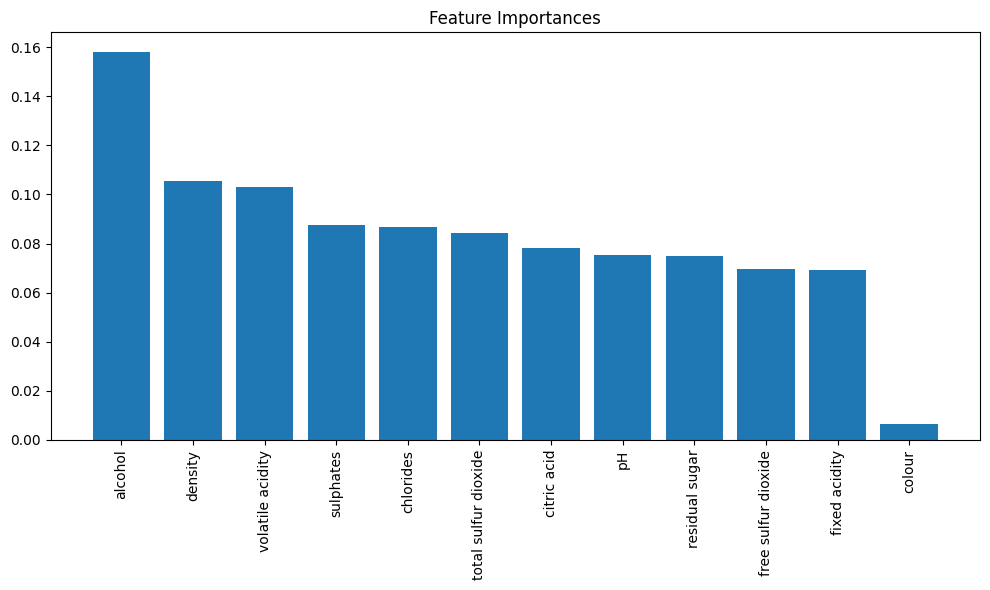

In [103]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = US_X_train.columns if hasattr(US_X_train, 'columns') else [f"f{i}" for i in range(len(importances))]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()